In [1]:
import pandas as pd
import numpy as np

crypto_prices = pd.read_csv("data/crypto_prices.csv", index_col=0, sep = ';')
tickers = ['BTC-USD', 'ETH-USD']

returns_pd = np.log(crypto_prices[tickers] / crypto_prices[tickers].shift(1))[1:501]
returns = returns_pd.values

In [2]:
from pyscarcopula import GumbelCopula

n = len(tickers)
copula = GumbelCopula(dim = n)

In [3]:
copula.sp_cdf()

exp(-((-log(u0))**r + (-log(u1))**r)**(1/r))

In [59]:
fit_result = copula.fit(data = returns, method = 'scar-m-ou', seed = 333)
fit_result

           message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
           success: True
            status: 0
               fun: 214.4423380246816
                 x: [ 1.769e+00  1.903e+00  1.294e+00]
               nit: 9
               jac: [ 3.065e-04  8.436e-04 -8.640e-04]
              nfev: 40
              njev: 10
          hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
              name: Gumbel copula
            method: scar-m-ou
 latent_process_tr: 500
        stationary: False
      M_iterations: 5

In [60]:
from pyscarcopula.stattests import gof_test

gof_test(copula, returns, fit_result, to_pobs=True)

CramerVonMisesResult(statistic=0.20724617487292107, pvalue=0.2538074819803948)

In [62]:
copula.get_sample(N = 1000, r = 1.2)

array([[0.3419145 , 0.75984069],
       [0.20100116, 0.99177628],
       [0.66445252, 0.00754752],
       ...,
       [0.47082079, 0.05504098],
       [0.19596989, 0.68140935],
       [0.41578829, 0.860515  ]])

In [63]:
from pyscarcopula.sampler.sampler_ou import stationary_state_ou

size = 2000
random_process_state = copula.transform(stationary_state_ou(fit_result.x, size))

copula.get_sample(N = size, r = random_process_state)

array([[0.28401498, 0.36302595],
       [0.53713253, 0.82384503],
       [0.55985623, 0.60546083],
       ...,
       [0.35917146, 0.84746179],
       [0.05060841, 0.12043532],
       [0.6049239 , 0.08584268]])

In [5]:
from pyscarcopula.metrics import risk_metrics

gamma = [0.95]
window_len = 250
latent_process_tr = 500
MC_iterations = [int(10**5)]
M_iterations = 5

#fastest calculations
# method = 'mle'
# marginals_method = 'normal'

#More precise calculations. For appropiate choice of latent_process_tr and M_iterations see README.md
method = 'scar-p-ou' # or use 'scar-m-ou'
marginals_method = 'johnsonsu'

count_instruments = len(tickers)
portfolio_weight = np.ones(count_instruments) / count_instruments
result = risk_metrics(copula,
                      returns,
                      window_len,
                      gamma,
                      MC_iterations,
                      marginals_method = marginals_method,
                      latent_process_type = method,
                      latent_process_tr = latent_process_tr,
                      optimize_portfolio = False,
                      portfolio_weight = portfolio_weight,
                      seed = 222,
                      M_iterations = M_iterations,
                      save_logs = False
                      )

calc marginals params
seed = 222
calc copula params


100%|██████████| 251/251 [17:32<00:00,  4.19s/it]


calc portfolio risks
gamma = 0.95, MC_iterations = 100000


100%|██████████| 251/251 [00:35<00:00,  7.07it/s]


In [6]:
var = result[0.95][100000]['var']
cvar = result[0.95][100000]['cvar']
portfolio_weight = result[0.95][100000]['weight']

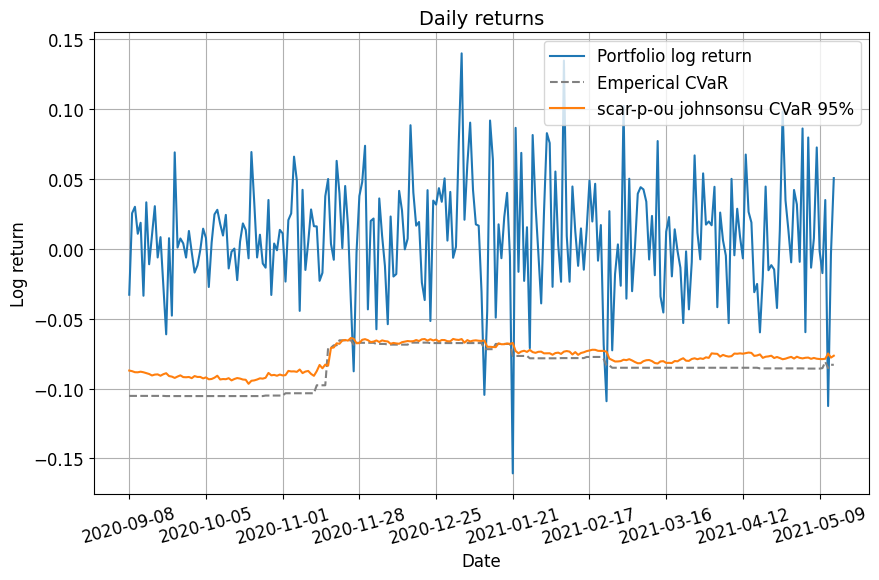

In [7]:
from pyscarcopula.metrics import cvar_emp_window
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker

pd_var_95 = pd.Series(data = -result[gamma[0]][MC_iterations[0]]['var'], index=returns_pd.index).shift(1)
pd_cvar_95 = pd.Series(data = -result[gamma[0]][MC_iterations[0]]['cvar'], index=returns_pd.index).shift(1)


weight = result[gamma[0]][MC_iterations[0]]['weight']

n = 1
m = 1
i1 = window_len
i2 = len(returns) - 1

fig,ax = plt.subplots(n,m,figsize=(10,6))
loc = plticker.MultipleLocator(base=27.0)

daily_returns = ((np.exp(returns_pd) - 1) * weight).sum(axis=1)
cvar_emp = cvar_emp_window(daily_returns.values, 1 - gamma[0], window_len)

ax.plot(np.clip(daily_returns, -0.2, 0.2)[i1:i2], label = 'Portfolio log return')
ax.plot(cvar_emp[i1:i2], label = 'Emperical CVaR', linestyle='dashed', color = 'gray')

ax.plot(pd_cvar_95[i1:i2], label= f'{method} {marginals_method} CVaR 95%')

ax.set_title(f'Daily returns', fontsize = 14)

ax.xaxis.set_major_locator(loc)
ax.set_xlabel('Date', fontsize = 12, loc = 'center')
ax.set_ylabel('Log return', fontsize = 12, loc = 'center')
ax.tick_params(axis='x', labelrotation = 15, labelsize = 12)
ax.tick_params(axis='y', labelsize = 12)
ax.grid(True)
ax.legend(fontsize=12, loc = 'upper right')